In [14]:
# %pip install statsmodels
# %pip install patsy


In [2]:
import pandas as pd 
import math
import matplotlib.pyplot as plt
import numpy as np
import datetime
from scipy.stats import chi2_contingency
import pandas as pd
import numpy as np
from sklearn import preprocessing, neighbors, svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error
import pickle
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import seaborn as sns
from xgboost import XGBClassifier


# df = pd.read_csv('data/2020 Line 280 AVL report.csv')
df = pd.read_csv('data/2019 Silver Streak allscripts.csv')
df = df.replace(',','', regex=True)
df['Actual Depart Hour'] = df['Actual Arrival'].str.split(':',expand=True)[0]
df['Actual Depart Hour'] = df['Actual Depart Hour'].astype(int)
df['Transit Date Month'] = df['Transit Date'].str.split('/',expand=True)[0]
df['Transit Date Month'] = df['Transit Date Month'].astype(int)

/Users/jairadhakrishnan/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# df1 = df.copy()
# df1 = df.loc[(df['Bus Stop ID'] == 775) | (df['Bus Stop ID'] == 782) | (df['Bus Stop ID'] == 733)]
# df1 = df.loc[(df['Bus Stop ID'] != 177)]
# df1 = df1.loc[(df1['Bus Stop ID'] != 738)]
# df1 = df1.loc[(df1['Bus Stop ID'] != 2199)]
# df1 = df1.loc[(df1['Bus Stop ID'] != 2384)]

df1 = pd.get_dummies(df, columns=['Actual Depart Hour', 'Transit Date Month', 'Day of Week', \
    'Miles from Prior Time Point', 'Bus Stop ID', 'Badge #'],prefix=['Enc_Hour_', 'Enc_Month_', 'Enc_Day_',\
        'Enc_Miles_', 'Enc_Stop_', 'Enc_Badge_'])
# df1 = pd.get_dummies(df1, columns=['Actual Depart Hour', 'Transit Date Month', 'Day of Week', \
#     'Miles from Prior Time Point'],prefix=['Enc_Hour_', 'Enc_Month_', 'Enc_Day_',\
#         'Enc_Miles_'])
# df1 = pd.get_dummies(df1, columns=['Transit Date Month'],prefix=['Enc_Month_'])

# df1['Transit Date Month'] = df1['Transit Date'].str.split('/',expand=True)[0]
df1.fillna(value = -9999)
enc = OneHotEncoder(handle_unknown='ignore')

df1['Difference (Minutes)'] = df1['Difference (Minutes)'].astype(int)
df1['Prev Departure Offset'] = df1['Prev Departure Offset'].astype(int)
# df1['Transit Date Month'] = df1['Transit Date Month'].astype(int)

# df.replace('?', -99999, inplace=True) #sees -99999 as outlier, ignores it
df1.drop(['Transit Date', 'Block #', 'Stop Sequence','Latitude','Longitude',\
        'Actual Arrival', 'Dwell Time', 'Actual Run Time',\
                'Actual Arrival DateTime', \
                            'Same Stop Prev Trip Departure Offset'\
                                ], 1, inplace=True)


# df1.drop(['Transit Date', 'Vehicle #', 'Block #', 'Route #', 'Trip #', 'Direction',\
#     'Pattern','Bus Stop Name', 'Stop Sequence','Latitude','Longitude','Scheduled Depart','Actual Depart',\
#         'Initial Performance Result','Reported Performance Results','Actual Arrival','Waivers',\
#             'Dwell Time', 'Actual Run Time', 'Scheduled Operating Speed','Actual Operating Speed',\
#                 'Run Time Variance','Day Type','Time Period', 'Scheduled Run Time',\
#                         'Scheduled Depart DateTime', 'Actual Depart DateTime', \
#                             'Same Stop Prev Trip Departure Offset'\
#                                 ], 1, inplace=True)



# print(df1.head)
# pd.to_numeric(df1['Actual Operating Speed'], errors='coerce')
X = np.array(df1.drop(['Difference (Minutes)'],1)) #using everything except class to train
Y = np.array(df1['Difference (Minutes)']) #class is the final result obviously
np.nan_to_num(X)
np.nan_to_num(Y)
pd.isnull(X)
np.nan_to_num(X)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2)

# lr_sgd = SGDRegressor(loss='huber', penalty='l1')
# lr_sgd = SGDRegressor(loss='huber', penalty='elasticnet')
lr_sgd = XGBClassifier(subsample = 0.7, max_depth = 4)
%time lr_sgd.fit(X_train, Y_train)

filename = 'models/2019_lr_sgd_model_9_15.sav'
pickle.dump(lr_sgd, open(filename, 'wb'))

plt.scatter(Y_test, lr_sgd.predict(X_test))
plt.grid()
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('scatter plot between actual y and predicted y')
plt.show()
print('Root Mean Squared Error :',math.sqrt(mean_squared_error(Y_test, lr_sgd.predict(X_test))))
print('Mean Absolute Error :',mean_absolute_error(Y_test, lr_sgd.predict(X_test)))

scores = cross_val_score(lr_sgd, X_test, Y_test, cv=5)

print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4), sharey=True)
# ax.plot(X_train, clf.fit(X_train, Y_train).predict(X_train), lw=2)
# ax.scatter(X_train[clf.support_], Y_train[clf.support_], facecolor="none",s=50)
# # ax.scatter(X_test[np.setdiff1d(np.arange(len(X_test)),clf.support_)],
# #            Y_test[np.setdiff1d(np.arange(len(X_test)), clf.support_)],
# #            facecolor="none", edgecolor="k", s=50)


# fig.text(0.5, 0.04, 'data', ha='center', va='center')
# fig.text(0.06, 0.5, 'target', ha='center', va='center', rotation='vertical')
# fig.suptitle("Support Vector Regression", fontsize=14)
# plt.show()

/var/folders/sl/46hc8zqn0l9_kwvskdqj7z8h0000gn/T/ipykernel_3846/4280839875.py:25: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df1.drop(['Transit Date', 'Block #', 'Stop Sequence','Latitude','Longitude',\
/var/folders/sl/46hc8zqn0l9_kwvskdqj7z8h0000gn/T/ipykernel_3846/4280839875.py:45: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = np.array(df1.drop(['Difference (Minutes)'],1)) #using everything except class to train
/Users/jairadhakrishnan/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [

[12:53:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [17]:

# df1 = df.copy()
# df1 = df.loc[(df['Bus Stop ID'] == 775) | (df['Bus Stop ID'] == 782) | (df['Bus Stop ID'] == 733)]





#################################################################################
# df1 = df.loc[(df['Bus Stop ID'] != 177)]
# df1 = df1.loc[(df1['Bus Stop ID'] != 738)]
# df1 = df1.loc[(df1['Bus Stop ID'] != 2199)]
# df1 = df1.loc[(df1['Bus Stop ID'] != 2384)]

# df1 = pd.get_dummies(df1, columns=['Actual Depart Hour', 'Transit Date Month', 'Day of Week', \
#     'Miles from Prior Time Point', 'Bus Stop ID'],prefix=['Enc_Hour_', 'Enc_Month_', 'Enc_Day_',\
#         'Enc_Miles_', 'Enc_Stop_'])
# # df1 = pd.get_dummies(df1, columns=['Actual Depart Hour', 'Transit Date Month', 'Day of Week', \
# #     'Miles from Prior Time Point'],prefix=['Enc_Hour_', 'Enc_Month_', 'Enc_Day_',\
# #         'Enc_Miles_'])
# # df1 = pd.get_dummies(df1, columns=['Transit Date Month'],prefix=['Enc_Month_'])

# # df1['Transit Date Month'] = df1['Transit Date'].str.split('/',expand=True)[0]
# df1.fillna(value = -9999)
# enc = OneHotEncoder(handle_unknown='ignore')

# df1['Difference (Minutes)'] = df1['Difference (Minutes)'].astype(int)
# df1['Prev Departure Offset'] = df1['Prev Departure Offset'].astype(int)
# # df1['Transit Date Month'] = df1['Transit Date Month'].astype(int)

# # df.replace('?', -99999, inplace=True) #sees -99999 as outlier, ignores it
# df1.drop(['Transit Date', 'Vehicle #', 'Block #', 'Route #', 'Trip #', 'Direction',\
#     'Pattern','Bus Stop Name', 'Stop Sequence','Latitude','Longitude','Scheduled Depart','Actual Depart',\
#         'Initial Performance Result','Reported Performance Results','Actual Arrival','Waivers',\
#             'Dwell Time', 'Actual Run Time', 'Scheduled Operating Speed','Actual Operating Speed',\
#                 'Run Time Variance','Day Type','Time Period', 'Scheduled Run Time',\
#                         'Scheduled Depart DateTime', 'Actual Depart DateTime', \
#                             'Same Stop Prev Trip Departure Offset'\
#                                 ], 1, inplace=True)
# print(df1.head)
# # pd.to_numeric(df1['Actual Operating Speed'], errors='coerce')
# X = np.array(df1.drop(['Difference (Minutes)'],1)) #using everything except class to train
# Y = np.array(df1['Difference (Minutes)']) #class is the final result obviously
# np.nan_to_num(X)
# np.nan_to_num(Y)
# pd.isnull(X)
# np.nan_to_num(X)

# X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2)

# clf = svm.SVR()
# %time clf.fit(X_train, Y_train)

# scores = cross_val_score(clf, X_test, Y_test, cv=5)

# print(scores)
# print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
#################################################################################





# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4), sharey=True)
# ax.plot(X_train, clf.fit(X_train, Y_train).predict(X_train), lw=2)
# ax.scatter(X_train[clf.support_], Y_train[clf.support_], facecolor="none",s=50)
# # ax.scatter(X_test[np.setdiff1d(np.arange(len(X_test)),clf.support_)],
# #            Y_test[np.setdiff1d(np.arange(len(X_test)), clf.support_)],
# #            facecolor="none", edgecolor="k", s=50)


# fig.text(0.5, 0.04, 'data', ha='center', va='center')
# fig.text(0.06, 0.5, 'target', ha='center', va='center', rotation='vertical')
# fig.suptitle("Support Vector Regression", fontsize=14)
# plt.show()

In [18]:
df1 = df.copy()


# df1 = pd.get_dummies(df1, columns=['Actual Depart Hour', 'Transit Date Month', 'Day of Week']\
#     ,prefix=['Enc_Hour_', 'Enc_Month_', 'Enc_Day_'])

df1.fillna(value = -9999)
enc = OneHotEncoder(handle_unknown='ignore')

df1['Scheduled Run Time'] = df1['Scheduled Run Time'].astype(int)
df1['Actual Run Time'] = df1['Actual Run Time'].astype(int)

df1.drop(['Transit Date', 'Vehicle #', 'Block #', 'Route #', 'Trip #', 'Direction',\
    'Pattern','Bus Stop Name', 'Stop Sequence','Latitude','Longitude','Scheduled Depart','Actual Depart',\
   'Miles from Prior Time Point', 'Bus Stop ID',\
       'Actual Depart Hour', 'Transit Date Month', 'Day of Week',\
        'Initial Performance Result','Reported Performance Results','Actual Arrival','Waivers',\
            'Dwell Time', 'Scheduled Operating Speed','Actual Operating Speed',\
                'Run Time Variance','Day Type','Time Period',\
                        'Scheduled Depart DateTime', 'Actual Depart DateTime', \
                            'Same Stop Prev Trip Departure Offset', \
                                'Difference (Minutes)', 'Prev Departure Offset'], 1, inplace=True)
# print(df1.head)
X = np.array(df1.drop(['Actual Run Time'],1)) #using everything except class to train
Y = np.array(df1['Actual Run Time']) #class is the final result obviously
np.nan_to_num(X)
np.nan_to_num(Y)
pd.isnull(X)
np.nan_to_num(X)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2)

lr_sgd = SGDRegressor(loss='huber')
%time lr_sgd.fit(X_train, Y_train)

filename = 'models/2019_lr_sgd_model_9_15.sav'
pickle.dump(lr_sgd, open(filename, 'wb'))

plt.scatter(Y_test, lr_sgd.predict(X_test))
plt.grid()
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('scatter plot between actual y and predicted y')
plt.show()
print('Root Mean Squared Error :',math.sqrt(mean_squared_error(Y_test, lr_sgd.predict(X_test))))
print('Mean Absolute Error :',mean_absolute_error(Y_test, lr_sgd.predict(X_test)))

scores = cross_val_score(lr_sgd, X_test, Y_test, cv=5)

print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4), sharey=True)
# ax.plot(X_train, clf.fit(X_train, Y_train).predict(X_train), lw=2)
# ax.scatter(X_train[clf.support_], Y_train[clf.support_], facecolor="none",s=50)
# # ax.scatter(X_test[np.setdiff1d(np.arange(len(X_test)),clf.support_)],
# #            Y_test[np.setdiff1d(np.arange(len(X_test)), clf.support_)],
# #            facecolor="none", edgecolor="k", s=50)


# fig.text(0.5, 0.04, 'data', ha='center', va='center')
# fig.text(0.06, 0.5, 'target', ha='center', va='center', rotation='vertical')
# fig.suptitle("Support Vector Regression", fontsize=14)
# plt.show()

/var/folders/sl/46hc8zqn0l9_kwvskdqj7z8h0000gn/T/ipykernel_23733/1868044830.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df1.drop(['Transit Date', 'Vehicle #', 'Block #', 'Route #', 'Trip #', 'Direction',\


KeyError: "['Vehicle #' 'Route #' 'Trip #' 'Direction' 'Pattern' 'Bus Stop Name'\n 'Scheduled Depart' 'Actual Depart' 'Initial Performance Result'\n 'Reported Performance Results' 'Waivers' 'Scheduled Operating Speed'\n 'Actual Operating Speed' 'Run Time Variance' 'Day Type' 'Time Period'\n 'Scheduled Depart DateTime' 'Actual Depart DateTime'] not found in axis"

In [ ]:
stopactual = df
stopactual['Actual Run Time'] = stopactual['Actual Run Time'].astype(int)
stopactual['Scheduled Run Time'] = stopactual['Scheduled Run Time'].astype(int)

f=plt.figure(figsize=(10,7))

ax1=f.add_subplot(111)
ax1.set_xlim(left = -25,right=100)
ax1.set_ylim(bottom=-25,top=100)
ax1.set(Title="2019 Bus Run Time Correlation with Scheduled Run Time")
# plt.ylim(0,15)
ax1.scatter(stopactual['Actual Run Time'], stopactual['Scheduled Run Time'])
plt.setp(ax1.get_xticklabels(), visible=False)
plt.legend()
plt.grid()

ax1.set(xlabel="Actual Run Time")
ax1.set(ylabel="Scheduled Run Time")

locs, labels = plt.xticks() 



plt.show()

df['Actual Run Time'].corr(df['Scheduled Run Time'])

In [ ]:
print(df.loc[df['Run Time Variance']==0].shape[0]/df.shape[0])

Wall time: 600 ms


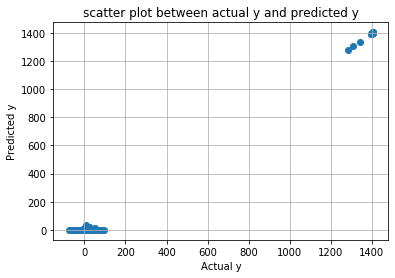

Root Mean Squared Error : 5.470263523814567
Mean Absolute Error : 2.7564572255815216
[0.96774294 0.98230823 0.97402959 0.96046101 0.89424458]
0.96 accuracy with a standard deviation of 0.03


In [ ]:
df1 = df.copy()


df1 = pd.get_dummies(df1, columns=['Actual Depart Hour', 'Transit Date Month', 'Day of Week']\
    ,prefix=['Enc_Hour_', 'Enc_Month_', 'Enc_Day_'])

df1.fillna(value = -9999)
enc = OneHotEncoder(handle_unknown='ignore')

df1['Scheduled Run Time'] = df1['Scheduled Run Time'].astype(int)
df1['Actual Run Time'] = df1['Actual Run Time'].astype(int)

df1.drop(['Transit Date', 'Vehicle #', 'Block #', 'Route #', 'Trip #', 'Direction',\
    'Pattern','Bus Stop Name', 'Stop Sequence','Latitude','Longitude','Scheduled Depart','Actual Depart',\
   'Miles from Prior Time Point', 'Bus Stop ID',
        'Initial Performance Result','Reported Performance Results','Actual Arrival','Waivers',\
            'Dwell Time', 'Scheduled Operating Speed','Actual Operating Speed',\
                'Run Time Variance','Day Type','Time Period',\
                        'Scheduled Depart DateTime', 'Actual Depart DateTime', \
                            'Same Stop Prev Trip Departure Offset', \
                                'Difference (Minutes)', 'Prev Departure Offset'], 1, inplace=True)
X = np.array(df1.drop(['Actual Run Time'],1)) #using everything except class to train
Y = np.array(df1['Actual Run Time']) #class is the final result obviously
np.nan_to_num(X)
np.nan_to_num(Y)
pd.isnull(X)
np.nan_to_num(X)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2)

lr_sgd = SGDRegressor(loss='huber')
%time lr_sgd.fit(X_train, Y_train)



plt.scatter(Y_test, lr_sgd.predict(X_test))
plt.grid()
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('scatter plot between actual y and predicted y')
plt.show()
print('Root Mean Squared Error :',math.sqrt(mean_squared_error(Y_test, lr_sgd.predict(X_test))))
print('Mean Absolute Error :',mean_absolute_error(Y_test, lr_sgd.predict(X_test)))

scores = cross_val_score(lr_sgd, X_test, Y_test, cv=5)
print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

In [ ]:
df1 = df.copy()
df1.fillna(value = -999999)
df1['Actual Run Time'] = df1['Actual Run Time'].astype(float)
df1['Scheduled Run Time'] = df1['Scheduled Run Time'].astype(float)


df1.drop(['Transit Date', 'Vehicle #', 'Block #', 'Route #', 'Trip #', 'Direction',\
    'Pattern','Bus Stop Name', 'Stop Sequence','Latitude','Longitude','Scheduled Depart','Actual Depart',\
   'Miles from Prior Time Point',
        'Initial Performance Result','Reported Performance Results','Actual Arrival','Waivers',\
            'Dwell Time', 'Scheduled Operating Speed','Actual Operating Speed',\
                'Run Time Variance','Day Type','Time Period',\
                        'Scheduled Depart DateTime', 'Actual Depart DateTime', \
                            'Same Stop Prev Trip Departure Offset', \
                                'Difference (Minutes)', 'Prev Departure Offset'], 1, inplace=True)

train=df1.sample(frac=0.8)
test=df1.drop(train.index)

# train = df1
# test = pd.read_csv('data/2020 Line 280 AVL allscripts.csv')

# test['Actual Depart Hour'] = test['Actual Depart'].str.split(':',expand=True)[0]
# test['Actual Depart Hour'] = test['Actual Depart Hour'].astype(int)
# test['Transit Date Month'] = test['Transit Date'].str.split('/',expand=True)[0]
# test['Transit Date Month'] = test['Transit Date Month'].astype(int)

model = smf.mixedlm('Q("Actual Run Time") ~ Q("Scheduled Run Time") + C(Q("Actual Depart Hour")) + C(Q("Transit Date Month")) + C(Q("Day of Week"))',data = train,groups = "Bus Stop ID").fit()
# print(model.summary())
test['Predicted Actual Run Time'] = model.predict(test)
test['Predict = Actual'] = test['Actual Run Time'] == test['Predicted Actual Run Time']

test['Predicted Error'] = abs(test['Actual Run Time']-test['Predicted Actual Run Time'])/test[['Actual Run Time', 'Predicted Actual Run Time']].max(axis=1)*100
print(test.head())

In [ ]:
fig = plt.figure(figsize = (16, 9))

ax = sns.distplot(model.resid, hist = False, kde_kws = {"shade" : True, "lw": 1}, fit = stats.norm)

ax.set_title("KDE Plot of Model Residuals (Blue) and Normal Distribution (Black)")
ax.set_xlabel("Residuals")

In [ ]:
fig = plt.figure(figsize = (16, 9))
ax = fig.add_subplot(111)

sm.qqplot(model.resid, dist = stats.norm, line = 's', ax = ax)

ax.set_title("Q-Q Plot")

In [ ]:
fig = plt.figure(figsize = (16, 9))

ax = sns.scatterplot(y = model.resid, x = model.fittedvalues)

ax.set_title("RVF Plot")
ax.set_xlabel("Fitted Values")
ax.set_ylabel("Residuals")

In [ ]:
fig = plt.figure(figsize = (16, 9))

ax = sns.boxplot(x = test['Bus Stop ID'], y = test['Predicted Error'])

ax.set_title("Distribution of Errors for Bus Stop ID")
ax.set_ylabel("Prediction Error")
ax.set_xlabel("Bus Stop ID")


In [ ]:
fig = plt.figure(figsize = (16, 9))
test1 = test.loc[test['Bus Stop ID'] != 177]
test1 = test1.loc[test1['Bus Stop ID'] != 2199]

ax = sns.boxplot(x = test1['Bus Stop ID'], y = test1['Predicted Error'])

ax.set_title("Distribution of Errors for Bus Stop ID")
ax.set_ylabel("Prediction Error")
ax.set_xlabel("Bus Stop ID")


In [ ]:
df3 = df.copy()
df3.fillna(value = -999999)
df3['Prev Departure Offset'] = df3['Prev Departure Offset'].astype(int)
df3['Difference (Minutes)'] = df3['Difference (Minutes)'].astype(int)

df3.drop(['Transit Date', 'Vehicle #', 'Block #', 'Route #', 'Trip #', 'Direction',\
    'Pattern','Bus Stop Name', 'Stop Sequence','Latitude','Longitude','Scheduled Depart','Actual Depart',\
        'Initial Performance Result','Reported Performance Results','Actual Arrival','Waivers',\
            'Dwell Time', 'Scheduled Operating Speed','Actual Operating Speed',\
                'Run Time Variance','Day Type','Time Period',\
                        'Scheduled Depart DateTime', 'Actual Depart DateTime', \
                            'Same Stop Prev Trip Departure Offset', \
                                 'Scheduled Run Time'], axis = 1, inplace=True)

train=df3.sample(frac=0.8)
test=df3.drop(train.index)

model = smf.mixedlm('Q("Prev Departure Offset") ~ Q("Difference (Minutes)") + C(Q("Actual Depart Hour")) + C(Q("Transit Date Month")) + C(Q("Day of Week")) + C(Q("Miles from Prior Time Point"))',data = df3,groups = "Bus Stop ID").fit()
model.summary()
test['Predicted Actual Run Time'] = model.predict(test)

print('Root Mean Squared Error :',math.sqrt(mean_squared_error(test['Actual Run Time'], test['Predicted Actual Run Time'])))
#scores = cross_val_score(model, X_test, Y_test, cv=5)
#print(scores)
#print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

Root Mean Squared Error : 26.99985542115473
